In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
! pip install finance-datareader

     |████████████████████████████████| 48 kB 2.5 MB/s 


In [3]:
import FinanceDataReader as fdr

# 삼전 코드
STOCK_CODE = '005930' 
# 기간 : 2010-01-01 ~ 2021-12-30 
dataset = fdr.DataReader(STOCK_CODE, start='2010-01-01', end='2021-12-30')

In [4]:
# 데이터 정보
print("데이터 정보")
print(dataset.info())
print()
print("데이터 결측값\n", dataset.isnull().sum())
print()
print(dataset.iloc[[0, -1], :])

데이터 정보
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2962 entries, 2010-01-04 to 2021-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2962 non-null   int64  
 1   High    2962 non-null   int64  
 2   Low     2962 non-null   int64  
 3   Close   2962 non-null   int64  
 4   Volume  2962 non-null   int64  
 5   Change  2962 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 162.0 KB
None

데이터 결측값
 Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

             Open   High    Low  Close    Volume    Change
Date                                                      
2010-01-04  16060  16180  16000  16180    239271  0.012516
2021-12-30  78900  79500  78100  78300  14236700 -0.006345


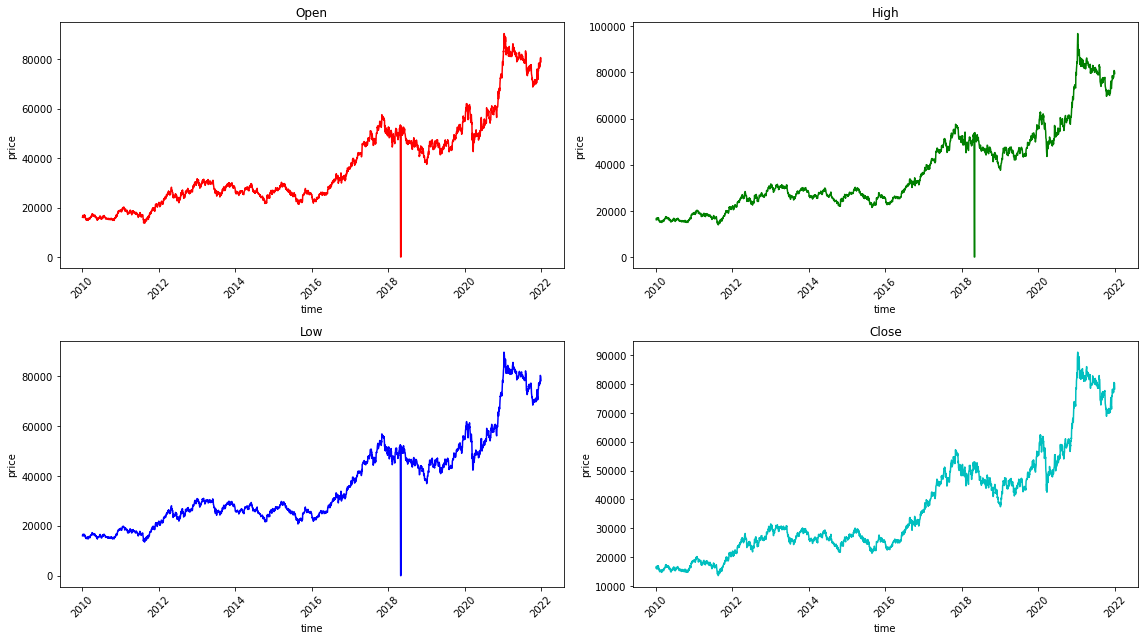

In [5]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(16, 9)
color = ['r', 'g', 'b', 'c']
for i, col in enumerate(dataset.columns[:-2]):
    pos = ax[i//2, i%2]
    pos.plot(dataset.index, dataset[col], c=color[i])
    pos.set_title(f'{col}')
    pos.set_xlabel('time')
    pos.set_ylabel('price')
    pos.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [6]:
dataset[dataset['Open'] == 0]

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-04-30,0,0,0,53000,0,0.0
2018-05-02,0,0,0,53000,0,0.0
2018-05-03,0,0,0,53000,0,0.0


In [7]:
# 0데이터 제거
drop_idx = dataset[dataset['Open'] == 0].index
dataset.drop(drop_idx, axis=0, inplace=True)

In [8]:
# 전처리
from sklearn.preprocessing import MinMaxScaler
# 시가, 고가, 저가, 종가
MM = MinMaxScaler()
scaled = MM.fit_transform(dataset.iloc[:, :4])
dataset_scaled = pd.DataFrame(scaled, columns=dataset.columns[:-2]) 
dataset_scaled.head()

,Open,High,Low,Close
0,0.031062,0.027034,0.033658,0.033333
1,0.037066,0.031861,0.037602,0.036693
2,0.037849,0.034757,0.040494,0.041602
3,0.040981,0.034757,0.037076,0.034367
4,0.035500,0.029930,0.035235,0.036434


In [9]:
def make_windowed_dataset(dataset, start_index, end_index, time_step, target_size, step, single_step=False):
    target = dataset['Close'].values
    dataset = dataset.to_numpy()
    data = []
    labels = []
    start_index = start_index + time_step
    if end_index is None:
        end_index = dataset.shape[0] - time_step
    
    for i in range(start_index, end_index):
        indexs = range(i - time_step, i, step)
        data.append(dataset[indexs])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [10]:
time_step = 30
train_size = int(dataset.shape[0] * 0.85)
x_train_single, y_train_single =  make_windowed_dataset(dataset_scaled, 0, train_size, time_step, 
                                                    0, 1, single_step = True)

x_test_single, y_test_single =  make_windowed_dataset(dataset_scaled, train_size, None, time_step, 
                                                    0, 1, single_step = True)

print(f"train shape : {x_train_single.shape}")
print(f"test shape : {x_test_single.shape}")

train shape : (2485, 30, 4)
test shape : (384, 30, 4)


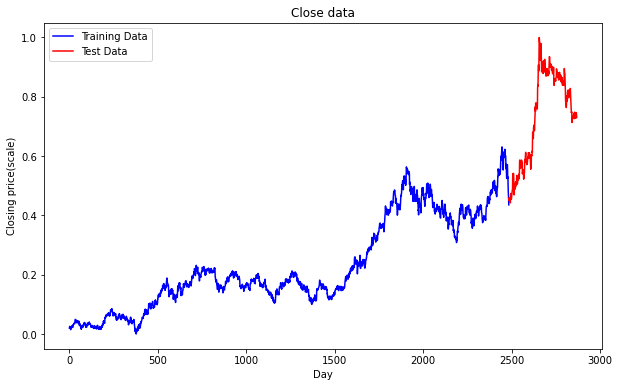

In [11]:
fig ,ax = plt.subplots(1, figsize=(10,6))
ax.plot(range(len(y_train_single)), y_train_single, c='b', label='Training Data')
ax.plot(range(len(y_train_single),len(y_test_single)+len(y_train_single)), y_test_single, c='r', label='Test Data')
ax.set_title('Close data')
ax.set_xlabel('Day')
ax.set_ylabel('Closing price(scale)')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
tf.random.set_seed(42)
np.random.seed(42)

RNN_model = tf.keras.models.Sequential()
RNN_model.add(tf.keras.layers.SimpleRNN(100, activation='tanh', input_shape=(time_step, 4)))
RNN_model.add(tf.keras.layers.Dense(1, activation='linear'))

loss = Huber()
RNN_model.compile(optimizer=Adam(1e-4), loss=loss, metrics=['mse'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('RNN', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [14]:
epoch = 200
batch_size = 32
RNN_model_history = RNN_model.fit(x_train_single, y_train_single, epochs=epoch, batch_size=batch_size,
                                            validation_data=(x_test_single, y_test_single), verbose=2,
                                            callbacks=[checkpoint, earlystopping])

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.01649, saving model to RNN/ckeckpointer.ckpt
78/78 - 9s - loss: 0.0078 - mse: 0.0155 - val_loss: 0.0165 - val_mse: 0.0330 - 9s/epoch - 111ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.01649 to 0.01374, saving model to RNN/ckeckpointer.ckpt
78/78 - 2s - loss: 1.7878e-04 - mse: 3.5756e-04 - val_loss: 0.0137 - val_mse: 0.0275 - 2s/epoch - 30ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.01374 to 0.01150, saving model to RNN/ckeckpointer.ckpt
78/78 - 2s - loss: 1.4389e-04 - mse: 2.8779e-04 - val_loss: 0.0115 - val_mse: 0.0230 - 2s/epoch - 29ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.01150 to 0.01000, saving model to RNN/ckeckpointer.ckpt
78/78 - 2s - loss: 1.3491e-04 - mse: 2.6983e-04 - val_loss: 0.0100 - val_mse: 0.0200 - 2s/epoch - 30ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.01000 to 0.00852, saving model to RNN/ckeckpointer.ckpt
78/78 - 2s - loss: 1.2093e-04 - mse: 2.4185e-04 - val_loss: 0.00

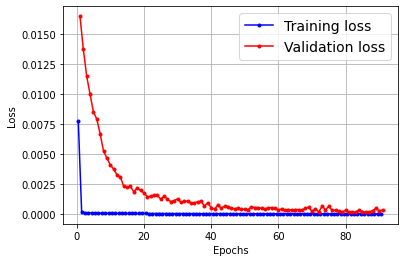

In [15]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(RNN_model_history.history["loss"], RNN_model_history.history["val_loss"])
plt.show()

In [16]:
RNN_model.load_weights(filename)

pred = RNN_model.predict(x_test_single)

In [17]:
RNN_model.evaluate(x_test_single, y_test_single)

12/12 [==============================] - 0s 6ms/step - loss: 1.7949e-04 - mse: 3.5897e-04


[0.00017948732420336455, 0.0003589746484067291]

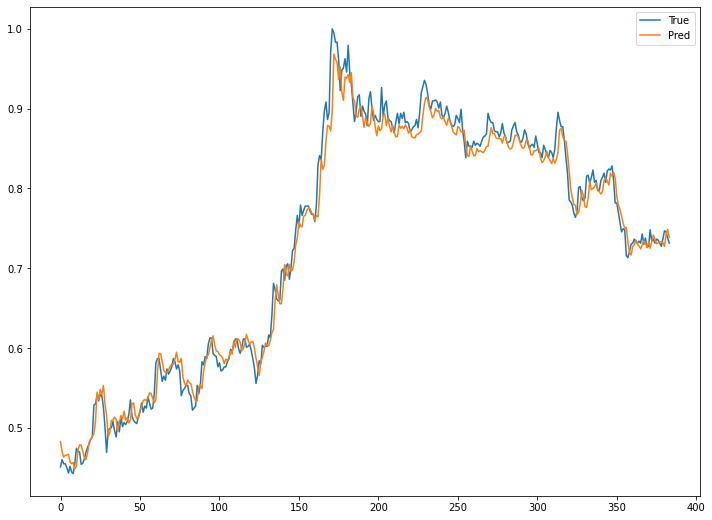

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_single), label='True')
plt.plot(pred, label='Pred')
plt.legend()
plt.show()

In [19]:
# lstm
LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(100, activation='tanh', input_shape=(time_step, 4)))
LSTM_model.add(tf.keras.layers.Dense(1, activation='linear'))

loss = Huber()
LSTM_model.compile(optimizer=Adam(1e-4), loss=loss, metrics=['mse'])

In [20]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('LSTM', 'LSTM.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [21]:
epoch = 200
batch_size = 32
LSTM_model_history = LSTM_model.fit(x_train_single, y_train_single, epochs=epoch, batch_size=batch_size,
                                            validation_data=(x_test_single, y_test_single), verbose=2,
                                            callbacks=[checkpoint, earlystopping])

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.00302, saving model to LSTM/LSTM.ckpt
78/78 - 5s - loss: 0.0027 - mse: 0.0054 - val_loss: 0.0030 - val_mse: 0.0060 - 5s/epoch - 62ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.00302 to 0.00120, saving model to LSTM/LSTM.ckpt
78/78 - 1s - loss: 1.4707e-04 - mse: 2.9413e-04 - val_loss: 0.0012 - val_mse: 0.0024 - 801ms/epoch - 10ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.00120 to 0.00080, saving model to LSTM/LSTM.ckpt
78/78 - 1s - loss: 1.1743e-04 - mse: 2.3487e-04 - val_loss: 7.9839e-04 - val_mse: 0.0016 - 777ms/epoch - 10ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.00080
78/78 - 1s - loss: 1.1196e-04 - mse: 2.2391e-04 - val_loss: 9.7353e-04 - val_mse: 0.0019 - 776ms/epoch - 10ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.00080
78/78 - 1s - loss: 1.1020e-04 - mse: 2.2040e-04 - val_loss: 9.3087e-04 - val_mse: 0.0019 - 746ms/epoch - 10ms/step
Epoch 6/200

Epoch 6: val_loss improved 

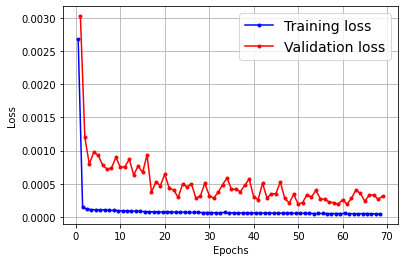

In [22]:
plot_learning_curves(LSTM_model_history.history["loss"], LSTM_model_history.history["val_loss"])
plt.show()

In [23]:
LSTM_model.load_weights(filename)

pred = LSTM_model.predict(x_test_single)

In [24]:
LSTM_model.evaluate(x_test_single, y_test_single)

12/12 [==============================] - 0s 4ms/step - loss: 1.9153e-04 - mse: 3.8305e-04


[0.00019152586173731834, 0.0003830517234746367]

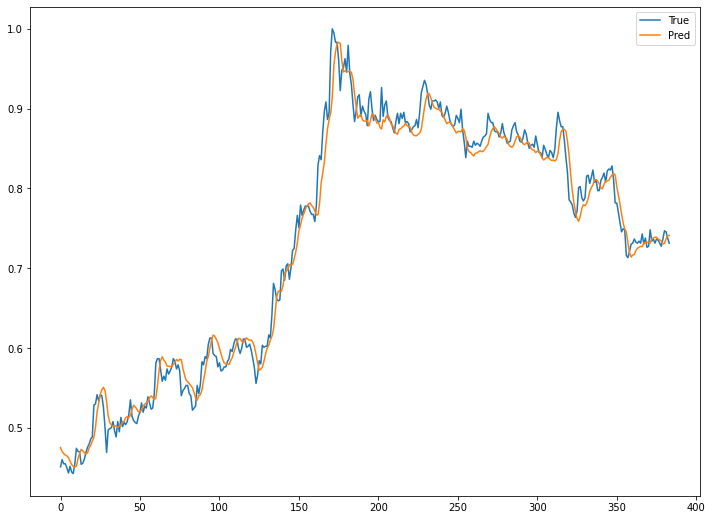

In [25]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_single), label='True')
plt.plot(pred, label='Pred')
plt.legend()
plt.show()

In [32]:
def show_plot(plot_data, delta, title):
    labels = ['past', 'True', 'rnn', 'lstm']
    marker = ['.-', 'rx', 'go', 'cs']
    time_steps = list(range(-plot_data[0].shape[0], 0))
                
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 3) * 2])
    plt.xlabel('Time_step')
    return plt

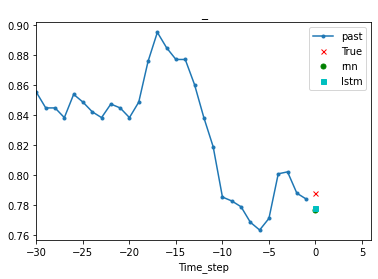

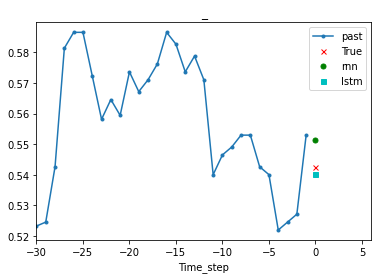

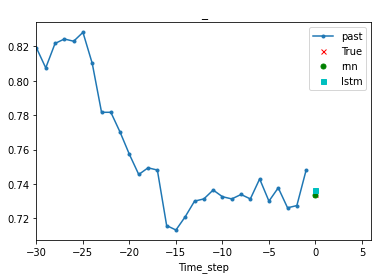

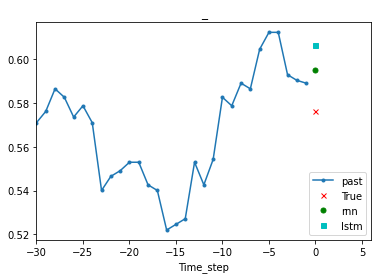

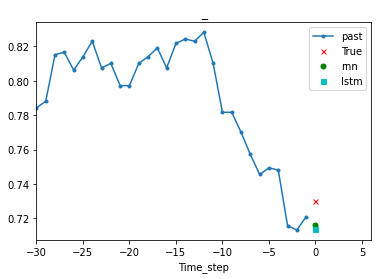

In [35]:
idx = np.random.choice(y_test_single.shape[0], 5)

for i in idx:
    rnn_sample = RNN_model.predict(x_test_single[i][np.newaxis, ...])
    lstm_sample = LSTM_model.predict(x_test_single[i][np.newaxis, ...])

    plot = show_plot([x_test_single[i][:, -1], y_test_single[i], rnn_sample, lstm_sample], 0, "_")
    plot.show()

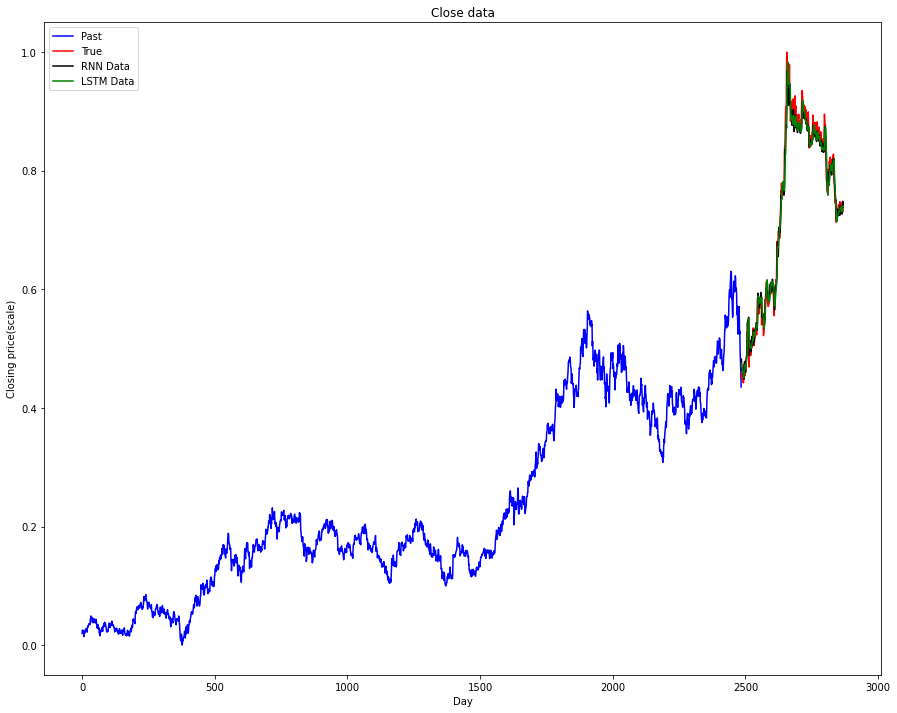

In [36]:
fig ,ax = plt.subplots(1, figsize=(15,12))
ax.plot(range(len(y_train_single)), y_train_single, c='b', label='Past')
ax.plot(range(len(y_train_single),len(y_test_single)+len(y_train_single)), y_test_single, c='r', label='True')
ax.plot(range(len(y_train_single),len(y_test_single)+len(y_train_single)), RNN_model.predict(x_test_single), c='k', label='RNN Data')
ax.plot(range(len(y_train_single),len(y_test_single)+len(y_train_single)), LSTM_model.predict(x_test_single), c='g', label='LSTM Data')
ax.set_title('Close data')
ax.set_xlabel('Day')
ax.set_ylabel('Closing price(scale)')
plt.legend()
plt.show()

# Pytorch

In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [39]:
# 데이터 loader 만들기
trains = torch.utils.data.TensorDataset(torch.FloatTensor(x_train_single).to(device), 
                                        torch.FloatTensor(y_train_single).to(device))
tests = torch.utils.data.TensorDataset(torch.FloatTensor(x_test_single).to(device), 
                                        torch.FloatTensor(y_test_single).to(device))

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=trains, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=tests, batch_size=batch_size, shuffle=False)

In [40]:
class RNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes, num_layers, device):
    super(RNN, self).__init__()
    # gpu체크
    self.device = device
    # hidden size
    self.hidden_size = hidden_size
    # layer 수
    self.num_layers = num_layers
    # 출력노드 수
    self.num_classes = num_classes
    # rnn 구조
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # 초기 hidden state 설정하기.
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) 
    # out : [배치, time_step(30), hidden size(100)]
    out, h_out = self.rnn(x, h0) 
    h_out = h_out.view(-1, self.hidden_size) 
    output = self.fc(h_out)
    return output

In [41]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        # gpu 체크
        self.device = device
        # 출력 노드 수
        self.num_classes = num_classes
        # layer 수
        self.num_layers = num_layers
        # 입력 차원
        self.input_size = input_size
        # hidden_size
        self.hidden_size = hidden_size
        # lstm 층
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # 출력층
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 초기 h 설정
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(self.device)
        # 초기 c 설정
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out